### Imports

In [36]:
import pandas as pd
import datetime
import os
import sys
import math
import matplotlib.pyplot as plt
import numpy as np
import warnings
from pandas.errors import SettingWithCopyWarning
from pandas import to_datetime
import statsmodels.api as sm
from statsmodels import regression
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
import pandas as pd
from scipy.ndimage import gaussian_filter1d
import seaborn as sns
import statsmodels.api as sm
import matplotlib.patches as mpatches

warnings.simplefilter(action='ignore', category=SettingWithCopyWarning)

### Parameters

In [37]:
buy_sell_threshold = 0.15
investment_ratio = 0.00005
long_short_ratio = 0.1
price_cap_lower = 0.5
stop_loss = 2
starting_balance = 1000000
fee = 0.005

run_optimizing = False
google_colab = False

### Data loading

In [38]:
if google_colab:
    from google.colab import drive
    drive.mount('/content/drive')
    !pip install -U -q PyDrive
    from pydrive.auth import GoogleAuth
    from pydrive.drive import GoogleDrive
    from google.colab import auth
    from oauth2client.client import GoogleCredentials
    # Authenticate and create the PyDrive client.
    auth.authenticate_user()
    gauth = GoogleAuth()
    gauth.credentials = GoogleCredentials.get_application_default()
    drive = GoogleDrive(gauth)
    id = "1PZQLyOiOpKtLt5BVAvWwQEnxZJzvLcD7"
    downloaded = drive.CreateFile({'id':id}) 
    downloaded.GetContentFile('Full trading data - All models.csv')  
    df = pd.read_csv('Full trading data - All models.csv')
    id = "13oSkK3IUv2Dlxbc_QILvLQ9tOlEKpqLk"
    downloaded = drive.CreateFile({'id':id}) 
    downloaded.GetContentFile('2011_11feb-2023mar_NSS__wo_moneyness_filtering_BID_ASK.csv')  
    df_options = pd.read_csv('2011_11feb-2023mar_NSS__wo_moneyness_filtering_BID_ASK.csv')
else:
    # Set the path to the root directory
    path = os.path.abspath(os.path.join(os.getcwd(), '../..'))
    # Read dataframes using Dask
    df = pd.read_csv(path + '/data/trading/Full trading data - All models - wo missing-filtering.csv')
    df_options = pd.read_csv(path + '/data/processed_data/2011_11feb-2023mar_NSS__wo_moneyness_filtering_BID_ASK.csv')

### Data processing

In [39]:
# Filter so its just data for 2015
#df = df[(df["Quote_date"] >= "2015-01-01") & (df["Quote_date"] <= "2018-12-31")]
#df = df[(df["Expiry_date"] >= "2015-01-01") & (df["Expiry_date"] <= "2018-12-31")]

# Choos 5% of the data randomly
#df = df.sample(frac=0.1, random_state=1)

In [40]:
lstm_mlp = True
bs_rolling = False
bs_garch = False
bs_iv = False
heston = False

if lstm_mlp:
    # Out of Quote_date	Expire_date	Price	Bid	Ask	Underlying_last	Strike	TTM	Delta	IV	R	Price_drop	Rolling	GARCH	BS-IV	Heston	LSTM-MLP, drop Rolling, GARCH, BS-IV, Heston
    df = df[['Quote_date', 'Expiry_date', 'Price', 'Bid', 'Ask', 'Underlying_last', 'Strike', 'TTM', 'Delta', 'IV', 'R', 'Price_drop', 'Option_ID', 'LSTM-MLP']]
    # Rename LSTM-MLP to Prediction
    df = df.rename(columns={'LSTM-MLP': 'Prediction'})
elif bs_rolling:
    df = df[['Quote_date', 'Expiry_date', 'Price', 'Bid', 'Ask', 'Underlying_last', 'Strike', 'TTM', 'Delta', 'IV', 'R', 'Price_drop', 'Option_ID', 'Rolling']]
    df = df.rename(columns={'Rolling': 'Prediction'})
elif bs_garch:
    df = df[['Quote_date', 'Expiry_date', 'Price', 'Bid', 'Ask', 'Underlying_last', 'Strike', 'TTM', 'Delta', 'IV', 'R', 'Price_drop', 'Option_ID', 'GARCH']]
    df = df.rename(columns={'GARCH': 'Prediction'})
elif bs_iv:
    df = df[['Quote_date', 'Expiry_date', 'Price', 'Bid', 'Ask', 'Underlying_last', 'Strike', 'TTM', 'Delta', 'IV', 'R', 'Price_drop', 'Option_ID', 'BS-IV']]
    df = df.rename(columns={'BS-IV': 'Prediction'})
elif heston:
    df = df[['Quote_date', 'Expiry_date', 'Price', 'Bid', 'Ask', 'Underlying_last', 'Strike', 'TTM', 'Delta', 'IV', 'R', 'Price_drop', 'Option_ID', 'Heston']]
    df = df.rename(columns={'Heston': 'Prediction'})

In [41]:
# Remane Expire_date to Expiry_date in df_options
df_options = df_options.rename(columns={'Expire_date': 'Expiry_date'})
df_options["Option_ID"] = df_options["Expiry_date"].astype(str) + "-" + df_options["Strike"].astype(str)
# Filter after 2015
df_options = df_options[(df_options["Quote_date"] >= "2015-01-01")]

In [42]:
df_combined = pd.merge(df_options, df, how='left', on=['Quote_date', 'Expiry_date', 'Strike', 'Option_ID'])
# Keep only Quote_date, expiry_date, Bid, Ask, Underlying_last and Option_ID from df_options and only the Prediction column from df
df_combined = df_combined[['Quote_date', 'Expiry_date', 'Bid_x', 'Ask_x', 'Underlying_last_x', "Price_x", "Delta_x", "TTM_x", "R_x", 'Option_ID', 'Prediction']]
df_combined = df_combined.rename(columns={'Bid_x': 'Bid', 'Ask_x': 'Ask', 'Underlying_last_x': 'Underlying_last', 'Price_x': 'Price', 'Delta_x': 'Delta', 'TTM_x': 'TTM', 'R_x': 'R'})

# Trading functions

In [43]:
def generate_buy_sell_signals(df, buy_threshold, sell_threshold):
    buy_signal = (df['Prediction'] - df['Ask']) / df['Ask'] >= buy_threshold
    sell_signal = (df['Bid'] - df['Prediction']) / df['Bid'] >= sell_threshold
    return buy_signal, sell_signal


def trader(df, buy_signal, sell_signal, starting_balance, price_cap_lower, investment_ratio, long_short_ratio, fee, stop_loss):
    df['Expiry_date'] = pd.to_datetime(df['Expiry_date'])
    df['Quote_date'] = pd.to_datetime(df['Quote_date'])
    df = df[df['Expiry_date'] <= df['Quote_date'].max()]
    
    df['Signal'] = 0
    df.loc[buy_signal, 'Signal'] = 1
    df.loc[sell_signal, 'Signal'] = -1

    df['Position_this_opt'] = 0
    df['Balance'] = -1000000    # Makes it easy to spot if balance has not been updated correctly

    df = df.sort_values('Quote_date')
    df['Option_ID'] = df['Option_ID'].astype(str)

    position_dict = {id:0 for id in df['Option_ID'].unique()}
    first_date = df['Quote_date'].min()
    total_balance_dict = {first_date: starting_balance}

    number_of_long_positions = 0
    number_of_short_positions = 0
    entry_prices = {}

    def operation(row):
        nonlocal number_of_long_positions
        nonlocal number_of_short_positions
        if row['Quote_date'] not in total_balance_dict.keys():
            total_balance_dict[row['Quote_date']] = total_balance_dict[max(total_balance_dict.keys())]

        balance = total_balance_dict[row['Quote_date']]
        position = position_dict[row['Option_ID']]

        # If price below cap, do nothing
        if row["Bid"] < price_cap_lower:
            row["Position_this_opt"] = position
            row["Balance"] = balance
            position_dict[row['Option_ID']] = position
            total_balance_dict[row['Quote_date']] = balance
            return row

        # Calculate net ratio
        if number_of_long_positions + number_of_short_positions == 0:
            net_ratio = 0
        else:
            net_ratio = (number_of_long_positions - number_of_short_positions) / (number_of_long_positions + number_of_short_positions)

        # Buy 
        if row['Signal'] == 1 and position <= 0 and row["Quote_date"] != row["Expiry_date"] and balance > 100 and net_ratio < long_short_ratio and row["Ask"] != 0 and row["Prediction"] != np.nan:
            amount_to_invest = balance * investment_ratio
            if amount_to_invest <= balance:
                balance -= amount_to_invest * (1 + fee)
                position += amount_to_invest / row['Ask']
                number_of_long_positions += 1
                entry_prices[row['Option_ID']] = row['Ask']

        # Sell
        elif row['Signal'] == -1 and position >= 0 and row["Quote_date"] != row["Expiry_date"] and balance > 100 and net_ratio > -long_short_ratio and row["Bid"] != 0 and row["Prediction"] != np.nan:
            amount_to_sell = balance * investment_ratio
            balance += amount_to_sell * (1 - fee)
            position -= amount_to_sell / row['Bid']
            number_of_short_positions += 1
            entry_prices[row['Option_ID']] = row['Bid'] 

        # Check if the stop-loss should be triggered
        if row['Option_ID'] in entry_prices:
            entry_price = entry_prices[row['Option_ID']]
            current_price = row['Ask'] if position > 0 else row['Bid']  # Check ask for long and bid for short
            # Long
            if position > 0 and (entry_price - current_price) / entry_price >= stop_loss:
                balance += position * row["Bid"] * (1 - fee) # Sell at bid price
                position = 0
                number_of_long_positions -= 1
                del entry_prices[row['Option_ID']]
            # Short
            elif position < 0 and  (current_price - entry_price) / entry_price >= stop_loss:
                balance -= position * row["Ask"] * (1 + fee) # Buy at ask price
                position = 0
                number_of_short_positions -= 1
                del entry_prices[row['Option_ID']]

        # Expire
        elif row["Quote_date"] == row["Expiry_date"] and position != 0:
            intrinsic_value = max(0, row['Underlying_last'] - row['Strike'])
            adjustment = intrinsic_value if position > 0 else -intrinsic_value
            balance += adjustment * abs(position)
            if position < 0:
                number_of_short_positions -= 1
            elif position > 0:
                number_of_long_positions -= 1
            position = 0
        
        
        row['Position_this_opt'] = position
        position_dict[row['Option_ID']] = position
        total_balance_dict[row['Quote_date']] = balance
        row['Balance'] = balance
        return row

    df = df.apply(operation, axis=1)
    df.loc[(df['Position_this_opt'] == 0), 'Balance'] = df['Quote_date'].map(total_balance_dict)
    return df

def calculate_options_value(df):
    df['Options_value'] = 0
    for date in df['Quote_date'].unique():
        # Net value
        options_value_sum = (df.loc[df['Quote_date'] == date, 'Position_this_opt'] * df.loc[df['Quote_date'] == date, 'Price']).sum()
        df.loc[df['Quote_date'] == date, 'Options_value'] = options_value_sum
        # Absolute value
        long_options_value_sum = (df.loc[(df['Quote_date'] == date) & (df['Position_this_opt'] > 0), 'Position_this_opt'] * df.loc[(df['Quote_date'] == date) & (df['Position_this_opt'] > 0), 'Price']).sum()
        short_options_value_sum = (df.loc[(df['Quote_date'] == date) & (df['Position_this_opt'] < 0), 'Position_this_opt'] * df.loc[(df['Quote_date'] == date) & (df['Position_this_opt'] < 0), 'Price']).sum()
        df.loc[df['Quote_date'] == date, 'Long_options_value'] = long_options_value_sum
        df.loc[df['Quote_date'] == date, 'Short_options_value'] = short_options_value_sum

        # Average delta value of all options combined
        # (position * price * delta) / (position * price)
        long_options_delta_sum = (df.loc[(df['Quote_date'] == date) & (df['Position_this_opt'] > 0), 'Position_this_opt'] * df.loc[(df['Quote_date'] == date) & (df['Position_this_opt'] > 0), 'Price'] * df.loc[(df['Quote_date'] == date) & (df['Position_this_opt'] > 0), 'Delta']).sum()
        short_options_delta_sum = (df.loc[(df['Quote_date'] == date) & (df['Position_this_opt'] < 0), 'Position_this_opt'] * df.loc[(df['Quote_date'] == date) & (df['Position_this_opt'] < 0), 'Price'] * df.loc[(df['Quote_date'] == date) & (df['Position_this_opt'] < 0), 'Delta']).sum()        
        if long_options_value_sum + short_options_value_sum == 0:
            average_delta = 0
        else:
            average_delta = (long_options_delta_sum + short_options_delta_sum) / (abs(long_options_value_sum) + abs(short_options_value_sum))

        df.loc[df['Quote_date'] == date, 'Average_delta'] = average_delta
    df['Total_value'] = df['Balance'] + df['Options_value']
    return df

### Analysis functions

In [44]:
def sharpe_ratio(df):
    df_sharpe = df.copy()
    # Make dataframe with 1 month risk free rate
    df_rf = df_sharpe.loc[(df_sharpe["TTM"] >= (20/365)) & (df_sharpe["TTM"] <= (40/365))] 
    df_rf = df_rf.groupby('Quote_date').last()["R"]

    # Original dataframe
    df_group = df.groupby('Quote_date').last()
    df_group["Returns"] = df_group["Total_value"].pct_change().fillna(0)

    # Check for NaN in returns
    print("Length of df_group: ", len(df_group), "Length of df_rf: ", len(df_rf))

    # Excess returns
    df_group["Excess_Returns"] = df_group["Returns"] - df_rf / 252

    # Sharpe ratio
    sharpe_ratio = np.sqrt(252) * (df_group["Excess_Returns"].mean() / df_group["Excess_Returns"].std())
    return sharpe_ratio

In [45]:
def sharpe_ratio_monthly(df):
    df_sharpe = df.copy()
    df_sharpe["YYYY-MM"] = df_sharpe["Quote_date"].dt.strftime("%Y-%m")
    
    # Find the risk-free rate for each month from a row with the same YYYY-MM and TTM close to one month
    df_rf = df_sharpe.loc[(df_sharpe["TTM"] >= (25/365)) & (df_sharpe["TTM"] <= (35/365))]  # Get the rows with TTM close to one month
    df_rf = df_rf.groupby("YYYY-MM").last()["R"]
    
    df_sharpe = df_sharpe.groupby("YYYY-MM").last()
    df_sharpe["Returns"] = df_sharpe["Total_value"].pct_change()
    
    df_sharpe["Excess_Returns"] = df_sharpe["Returns"] - df_rf / 12
    sharpe_ratio = np.sqrt(12) * (df_sharpe["Excess_Returns"].mean() / df_sharpe["Excess_Returns"].std())
    
    return sharpe_ratio

In [46]:
def sortino_ratio(df):
    df_sharpe = df.copy()
    # Make dataframe with 1 month risk free rate
    df_rf = df_sharpe.loc[(df_sharpe["TTM"] >= (25/365)) & (df_sharpe["TTM"] <= (35/365))] 
    df_rf = df_rf.groupby('Quote_date').last()["R"]

    df_group = df.groupby('Quote_date').last()
    df_group['Excess_Returns'] = df_group['Total_value'].pct_change().fillna(0) - df_rf / 252

    sortino_ratio = np.sqrt(252) * (df_group["Excess_Returns"].mean() / df_group.loc[df_group["Excess_Returns"] < 0, "Excess_Returns"].std())
    return sortino_ratio

In [47]:
def capm(df_capm):
    df_capm = df_capm.groupby('Quote_date').last()
    df_capm = df_capm[['Total_value', 'Underlying_last']].pct_change()
    
    # For the first day in every year, set the returns to 0
    df_capm['Year'] = df_capm.index.year
    df_capm['First_day_of_year'] = df_capm.groupby('Year')['Total_value'].transform('idxmin')
    df_capm.loc[df_capm.index == df_capm['First_day_of_year'], 'Total_value'] = 0
    df_capm.drop(columns=['Year', 'First_day_of_year'], inplace=True)
    df_capm.dropna(inplace=True)
    
    X = df_capm['Underlying_last']
    y = df_capm['Total_value']

    X = sm.add_constant(X) # Adding a constant term for the intercept in the model

    model = sm.OLS(y, X)
    results = model.fit()

    alpha = results.params['const'] * 252
    beta = results.params['Underlying_last']
    
    # Calculate t-statistics
    t_stats = results.tvalues
    alpha_t_statistic = t_stats['const'] * 252
    beta_t_statistic = t_stats['Underlying_last']

    # Get the p-values
    p_values = results.pvalues
    alpha_p_value = p_values['const']
    beta_p_value = p_values['Underlying_last']

    # Standard Errors
    std_err = results.bse
    alpha_std_err = std_err['const'] * 252
    beta_std_err = std_err['Underlying_last']

    def significance_marker(p):
        if p < 0.01:
            return "***"
        elif p < 0.05:
            return "**"
        elif p < 0.1:
            return "*"
        else:
            return ""

    print(f"Alpha: {alpha} SE: {alpha_std_err} p-value: {alpha_p_value} {significance_marker(alpha_p_value)}")
    print(f"Beta: {beta} SE: {beta_std_err} p-value: {beta_p_value} {significance_marker(beta_p_value)}")

    return alpha, beta, alpha_std_err, beta_std_err, alpha_p_value, beta_p_value

In [48]:
def max_drawdown(df):
    df_group = df.groupby('Quote_date').last()
    df_group['Roll_Max'] = df_group['Total_value'].cummax()
    df_group['Drawdown'] = df_group['Total_value'] / df_group['Roll_Max'] - 1.0
    df_group['Drawdown'].min()
    return df_group['Drawdown'].min() * 100

In [49]:
def print_results(df, starting_balance):
    ending_balance = df['Balance'].iloc[-1]
    profit = ending_balance - starting_balance
    num_trades = df[df["Price"] > 1]["Signal"].abs().sum()
    profit_per_trade = profit / num_trades

    df['Quote_date'] = pd.to_datetime(df['Quote_date'])
    trading_days = df['Quote_date'].unique().shape[0] - 1
    profit_per_day = profit / trading_days
    num_days = (df['Quote_date'].max() - df['Quote_date'].min()).days

    annualized_return = ((ending_balance / starting_balance)**(365/num_days) - 1)*100

    print(f"Starting balance: {starting_balance}")
    print(f"Ending balance: {ending_balance.round(0)}")
    print(f"Profit: {profit.round(0)}")
    print(f"Profit per trade: {profit_per_trade.round(2)}")
    print(f"Profit per trading day: {profit_per_day.round(2)}")
    print(f"Sharpe ratio: {sharpe_ratio_monthly(df).round(2)}")
    print(f"CAPM alpha: {capm_alpha(df).round(2)}")
    print(f"Annualized return in percent: {annualized_return.round(2)}")
    print(f"Max drawdown: {max_drawdown(df).round(2)}")

In [50]:
sns.set(style="whitegrid", font='serif', font_scale=1.2)

color = '#1982C4'
color2 = '#FF595E'
color3 = '#8AC926'
color4 = "#FFCA3A"
color5 = "#6A4C93"

def plot(df):
    # Just keep one row per Quote_date, and that should be the last row
    df = df.groupby('Quote_date').last()

    fig, ax1 = plt.subplots()

    ax1.plot(df['Total_value'], label='Total value', color=color)
    ax1.plot(df['Balance'], label='Cash', color=color2)
    #ax1.plot(df['Options_value'], label='Net value of options', color=color3)
    ax1.plot(df["Long_options_value"], label="Value of long position", color=color5)
    ax1.plot(df["Short_options_value"], label="Value of short position", color=color3)

    # Use gausian filter to smooth delta
    #df['Average_delta'] = gaussian_filter1d(df['Average_delta'], sigma=1)

    # Plot delta on seperate y-axis
    ax2 = ax1.twinx()
    ax2.plot(df['Average_delta'], label='Delta', color=color4) 
    
    ax1.set_title('Portfolio value over time')

    # Make plot smaller
    plt.xticks(rotation=45)

    # Create a legend for all the lines
    lines1, labels1 = ax1.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()

    lines = lines1 + lines2
    labels = labels1 + labels2

    ax1.legend(lines, labels, loc=0)
    
    plt.show()

## Run the code

Run by year

Alpha: 0.13391620290728523 SE: 0.06980171146563306 p-value: 0.05619274848448107 *
Beta: -0.24471236882005928 SE: 0.028542129955248498 p-value: 1.0942760658169416e-15 ***


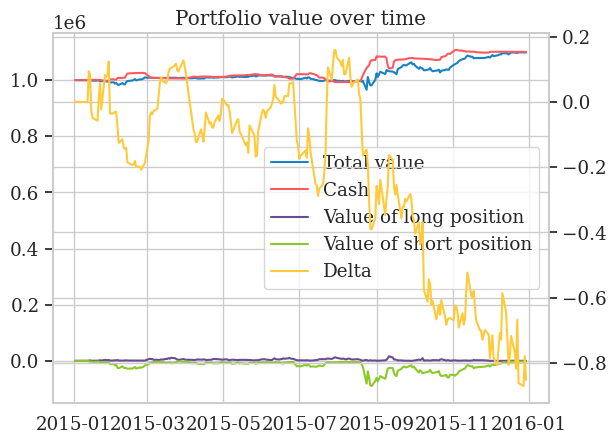

NaN in Returns: 0
NaN in Excess_Returns: 17
Standard Deviation of Excess_Returns: 0.005614794538150271
Alpha: 0.2621346987167545 SE: 0.06646321403025746 p-value: 0.0001044208031865802 ***
Beta: -0.1478672507734229 SE: 0.03218155388050027 p-value: 6.9121075818086485e-06 ***


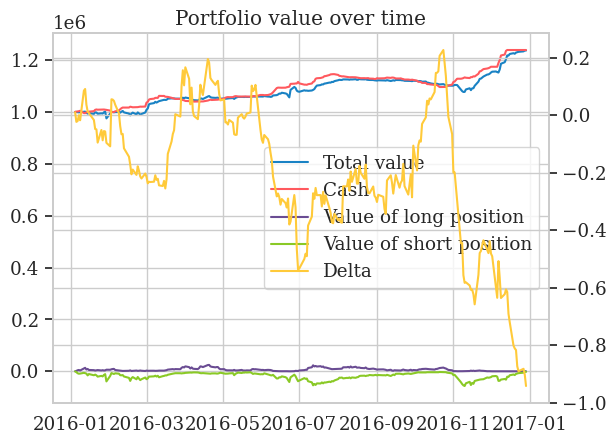

NaN in Returns: 0
NaN in Excess_Returns: 17
Standard Deviation of Excess_Returns: 0.004477778657805
Alpha: 0.0996273250149858 SE: 0.09985931185813945 p-value: 0.31941641264155096 
Beta: 0.5083411822623904 SE: 0.09417585869386509 p-value: 1.586896346691138e-07 ***


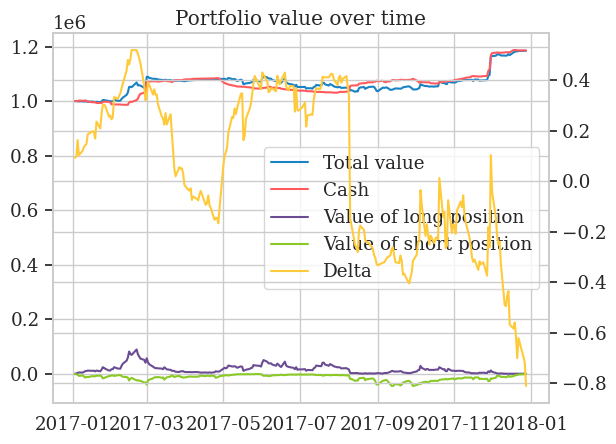

NaN in Returns: 0
NaN in Excess_Returns: 17
Standard Deviation of Excess_Returns: 0.006733371877191427
Alpha: 0.5324389627070301 SE: 0.1455150469918105 p-value: 0.00030929905800966854 ***
Beta: 0.013555720871836829 SE: 0.05381958718090351 p-value: 0.8013475441025207 


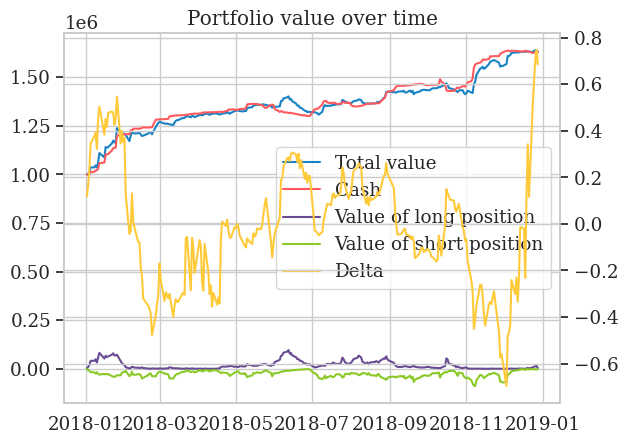

NaN in Returns: 0
NaN in Excess_Returns: 15
Standard Deviation of Excess_Returns: 0.009533082298329868
Alpha: 0.3810915975640268 SE: 0.15020719859989723 p-value: 0.01180383231952158 **
Beta: 0.06404857933666593 SE: 0.07429929477848535 p-value: 0.3895182384179019 


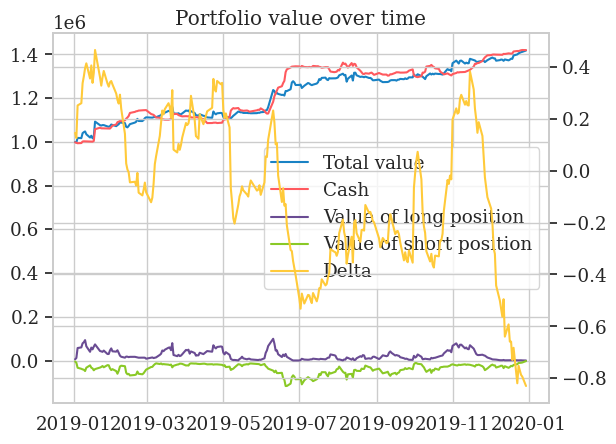

NaN in Returns: 0
NaN in Excess_Returns: 15
Standard Deviation of Excess_Returns: 0.009656421410129101
Alpha: 0.7168190843030607 SE: 0.2980087456368207 p-value: 0.016895568708366632 **
Beta: -0.05535496411043088 SE: 0.054147711312408676 p-value: 0.307645303121037 


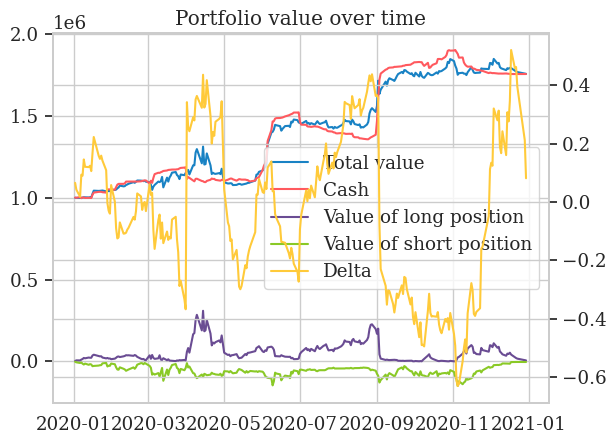

NaN in Returns: 0
NaN in Excess_Returns: 16
Standard Deviation of Excess_Returns: 0.019914506259583263
Alpha: 0.38873279495003926 SE: 0.14678747317789367 p-value: 0.008622506322281911 ***
Beta: 0.18207897777786897 SE: 0.07024013993310992 p-value: 0.010115550825494757 **


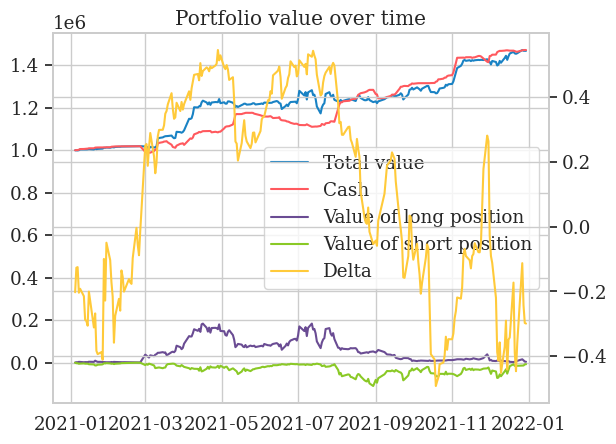

NaN in Returns: 0
NaN in Excess_Returns: 17
Standard Deviation of Excess_Returns: 0.00940289340127297
Alpha: 0.42792611427160737 SE: 0.26534488638856407 p-value: 0.10805767130667485 
Beta: 0.2441887735277087 SE: 0.06989527045880249 p-value: 0.000562666821419282 ***


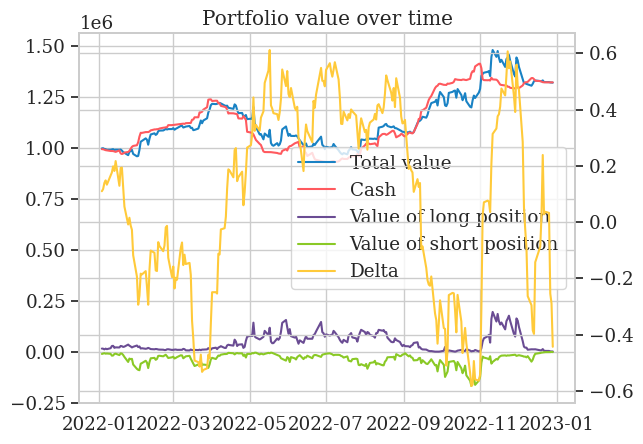

NaN in Returns: 0
NaN in Excess_Returns: 17
Standard Deviation of Excess_Returns: 0.018155060378365364
Alpha: 0.507828175571838 SE: 0.26581028490896486 p-value: 0.06110491677186385 *
Beta: 0.30873101579847967 SE: 0.09947581020868473 p-value: 0.0029744353347959437 ***


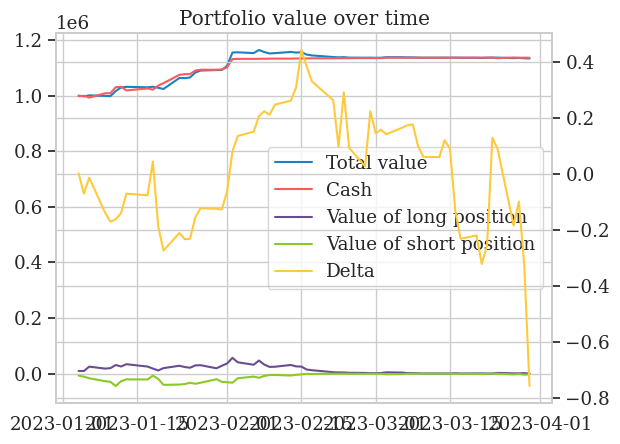

NaN in Returns: 0
NaN in Excess_Returns: 18
Standard Deviation of Excess_Returns: 0.010224573807817694


,Year,Starting balance,Ending balance,Profit,Profit per trade,Profit per trading day,Sharpe ratio,Sortino ratio,Annualized return in percent,Max drawdown,CAPM alpha,CAPM beta,CAPM alpha p-value,CAPM beta p-value
0,2015,1000000,1100682.0,100682.0,2.49,402.73,1.06,1.49,10.16,-5.04,13.39,-0.24,0.06,0.00
1,2016,1000000,1238474.0,238474.0,5.47,957.73,2.21,3.07,24.22,-4.46,26.21,-0.15,0.00,0.00
2,2017,1000000,1185628.0,185628.0,3.07,748.50,1.54,3.94,18.90,-5.23,9.96,0.51,0.32,0.00
3,2018,1000000,1628430.0,628430.0,4.82,2513.72,3.34,6.77,63.95,-6.74,53.24,0.01,0.00,0.80
4,2019,1000000,1419763.0,419763.0,4.16,1713.32,2.19,4.44,42.39,-4.56,38.11,0.06,0.01,0.39
5,2020,1000000,1756568.0,756568.0,2.73,3050.68,2.25,3.06,76.20,-17.94,71.68,-0.06,0.02,0.31
6,2021,1000000,1472340.0,472340.0,2.52,1935.82,2.65,3.85,48.03,-8.53,38.87,0.18,0.01,0.01
7,2022,1000000,1322991.0,322991.0,1.07,1271.62,1.17,1.76,32.81,-20.68,42.79,0.24,0.11,0.00
8,2023,1000000,1135842.0,135842.0,3.14,2302.41,4.60,21.82,72.80,-2.63,50.78,0.31,0.06,0.00


In [53]:
if run_optimizing == False:    
    # Initialize an empty DataFrame to store the results
    results = pd.DataFrame(columns=["Year", "Starting balance", "Ending balance", "Profit", "Profit per trade", "Profit per trading day", 
                                    "Sharpe ratio", "Sortino ratio", "Annualized return in percent", "Max drawdown", "CAPM alpha", "CAPM beta", "CAPM alpha p-value", "CAPM beta p-value"])

    # Get the list of years present in the data
    df_combined['Quote_date'] = pd.to_datetime(df_combined['Quote_date'])
    years = df_combined['Quote_date'].dt.year.unique()

    # Sort the years
    years.sort()

    total_dataframe_for_analysis = pd.DataFrame()
    # Iterate over each year
    for year in years:
        df_year = df_combined[df_combined['Quote_date'].dt.year == year].copy()
        
        if not df_year.empty:
            # Execute operations
            buy_signal, sell_signal = generate_buy_sell_signals(df_year, buy_sell_threshold, buy_sell_threshold)
            df_year = trader(df_year, buy_signal, sell_signal, starting_balance, price_cap_lower, investment_ratio, long_short_ratio, fee, stop_loss)
            df_year = calculate_options_value(df_year)

            # Calculate metrics
            ending_balance = df_year['Balance'].iloc[-1]
            profit = ending_balance - starting_balance
            num_trades = df_year[df_year["Price"] > 1]["Signal"].abs().sum()
            profit_per_trade = profit / num_trades

            trading_days = df_year['Quote_date'].unique().shape[0] - 1
            profit_per_day = profit / trading_days
            num_days = (df_year['Quote_date'].max() - df_year['Quote_date'].min()).days

            annualized_return = ((ending_balance / starting_balance)**(365/num_days) - 1)*100

            alpha, beta, alpha_std_err, beta_std_err, alpha_p_value, beta_p_value = capm(df_year)

            plot(df_year)

            # Print number of nan values
            # Drop all rows with nan values
            df_year = df_year.dropna()            
            # Create a DataFrame for this year's metrics
            year_metrics = pd.DataFrame({
                "Year": [year], 
                "Starting balance": [starting_balance], 
                "Ending balance": [ending_balance.round(0)], 
                "Profit": [profit.round(0)], 
                "Profit per trade": [profit_per_trade.round(2)], 
                "Profit per trading day": [profit_per_day.round(2)],
                "Sharpe ratio": [sharpe_ratio(df_year).round(2)],
                "Sortino ratio": [sortino_ratio(df_year).round(2)], 
                "Annualized return in percent": [annualized_return.round(2)], 
                "Max drawdown": [max_drawdown(df_year).round(2)],
                "CAPM alpha": [(alpha*100).round(2)],
                "CAPM beta": [beta.round(2)],
                "CAPM alpha p-value": [alpha_p_value.round(2)],
                "CAPM beta p-value": [beta_p_value.round(2)]
            })
            # Add metrics to the results DataFrame
            results = pd.concat([results, year_metrics])

            total_dataframe_for_analysis = pd.concat([total_dataframe_for_analysis, df_year])

    # Reset index of the results DataFrame
    results.reset_index(drop=True, inplace=True)

    # Print the results DataFrame
    display(results)

In [54]:
display(total_dataframe_for_analysis)

,Quote_date,Expiry_date,Bid,Ask,Underlying_last,Price,Delta,TTM,R,Option_ID,Prediction,Signal,Position_this_opt,Balance,Options_value,Long_options_value,Short_options_value,Average_delta,Total_value
20125,2015-01-12,2015-03-27,41.29,42.71,2028.56,42.000,0.42129,0.20274,0.00032,2015-03-27-2055.0,40.770054,0,0.0,1.000146e+06,-295.688566,277.745936,-573.434501,-0.000768,9.998506e+05
20120,2015-01-12,2015-03-27,55.21,56.90,2028.56,56.055,0.49372,0.20274,0.00032,2015-03-27-2030.0,54.632893,0,0.0,1.000146e+06,-295.688566,277.745936,-573.434501,-0.000768,9.998506e+05
20121,2015-01-12,2015-03-27,52.29,53.90,2028.56,53.095,0.47911,0.20274,0.00032,2015-03-27-2035.0,51.736744,0,0.0,1.000146e+06,-295.688566,277.745936,-573.434501,-0.000768,9.998506e+05
20122,2015-01-12,2015-03-27,49.40,51.00,2028.56,50.200,0.46545,0.20274,0.00032,2015-03-27-2040.0,48.841747,0,0.0,1.000146e+06,-295.688566,277.745936,-573.434501,-0.000768,9.998506e+05
20123,2015-01-12,2015-03-27,46.60,48.10,2028.56,47.350,0.45038,0.20274,0.00032,2015-03-27-2045.0,46.086243,0,0.0,1.000146e+06,-295.688566,277.745936,-573.434501,-0.000768,9.998506e+05
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11669654,2023-03-30,2023-03-31,613.70,616.80,4050.95,615.250,1.00000,0.00274,0.04740,2023-03-31-3435.0,616.627700,0,0.0,1.135842e+06,-2776.092648,17.607753,-2793.700401,-0.756772,1.133066e+06
11669653,2023-03-30,2023-03-31,618.80,621.80,4050.95,620.300,1.00000,0.00274,0.04740,2023-03-31-3430.0,621.603400,0,0.0,1.135842e+06,-2776.092648,17.607753,-2793.700401,-0.756772,1.133066e+06
11669652,2023-03-30,2023-03-31,623.80,626.80,4050.95,625.300,1.00000,0.00274,0.04740,2023-03-31-3425.0,626.579100,0,0.0,1.135842e+06,-2776.092648,17.607753,-2793.700401,-0.756772,1.133066e+06
11669651,2023-03-30,2023-03-31,628.50,631.80,4050.95,630.150,1.00000,0.00274,0.04740,2023-03-31-3420.0,631.554750,0,0.0,1.135842e+06,-2776.092648,17.607753,-2793.700401,-0.756772,1.133066e+06


In [55]:
# Calculate capm for the total dataframe ignoring the first day of the year each year
alpha, beta, alpha_std_err, beta_std_err, alpha_p_value, beta_p_value = capm(total_dataframe_for_analysis)

Alpha: 0.3436690480591207 SE: 0.06310419305045205 p-value: 5.768864382900336e-08 ***
Beta: 0.04746585501709181 SE: 0.021104685517604832 p-value: 0.024614144958249748 **


In [57]:
display(results)

,Year,Starting balance,Ending balance,Profit,Sharpe ratio,Sortino ratio,Annualized return in percent,Max drawdown,CAPM alpha,CAPM beta,CAPM alpha p-value,CAPM beta p-value
0,2015,1000000,1100682,100682,1.06000,1.4900,10.1600,-5.0400,13.39000,-0.24000,0.06000,0.00000
1,2016,1000000,1238474,238474,2.21000,3.0700,24.2200,-4.4600,26.21000,-0.15000,0.00000,0.00000
2,2017,1000000,1185628,185628,1.54000,3.9400,18.9000,-5.2300,9.96000,0.51000,0.32000,0.00000
3,2018,1000000,1628430,628430,3.34000,6.7700,63.9500,-6.7400,53.24000,0.01000,0.00000,0.80000
4,2019,1000000,1419763,419763,2.19000,4.4400,42.3900,-4.5600,38.11000,0.06000,0.01000,0.39000
5,2020,1000000,1756568,756568,2.25000,3.0600,76.2000,-17.9400,71.68000,-0.06000,0.02000,0.31000
6,2021,1000000,1472340,472340,2.65000,3.8500,48.0300,-8.5300,38.87000,0.18000,0.01000,0.01000
7,2022,1000000,1322991,322991,1.17000,1.7600,32.8100,-20.6800,42.79000,0.24000,0.11000,0.00000
Average,2018,1000000,1390609,390609,2.05125,3.5475,39.5825,-9.1475,36.78125,0.06875,0.06625,0.18875


In [62]:
# Drop 2023
results = results[results["Year"] != 2023]


# Add a final row to the results DataFrame with the average metrics
results.loc["Average"] = results.mean()

# Turn year, starting balance and ending balance, profit into integers
results[["Year", "Starting balance", "Ending balance", "Profit"]] = results[["Year", "Starting balance", "Ending balance", "Profit"]].astype(int)
# Rename the columns to  Year &  Starting &  Ending &  Profit &  Sharpe  &  alpha &  Return &  MDD \\
results.columns = ["Year", "Starting", "Ending", "Profit", "Sharpe", "Sortino", "Return", "MDD", "alpha"]
# Round to 2 decimals
float_cols = ["Sharpe", "alpha", "Return", "MDD"]
# Turn the columns into floats
results[float_cols] = results[float_cols].astype(float)

# Rename the columns to  Year &  Starting &  Ending &  Profit &  Sharpe  &  alpha &  Return &  MDD \\
results.columns = ["Year", "Starting", "Ending", "Profit", "Sharpe", "Sortino", "Return", "MDD", "alpha"]

results[float_cols] = results[float_cols].round(2)
print(results.to_latex(index=False, float_format="%.2f"))

\begin{tabular}{rrrrrrrrr}
\toprule
Year & Starting & Ending & Profit & Sharpe & Sortino & Return & MDD & alpha \\
\midrule
2015 & 1000000 & 1100682 & 100682 & 1.06 & 1.49 & 10.16 & -5.04 & 13.39 \\
2016 & 1000000 & 1238474 & 238474 & 2.21 & 3.07 & 24.22 & -4.46 & 26.21 \\
2017 & 1000000 & 1185628 & 185628 & 1.54 & 3.94 & 18.90 & -5.23 & 9.96 \\
2018 & 1000000 & 1628430 & 628430 & 3.34 & 6.77 & 63.95 & -6.74 & 53.24 \\
2019 & 1000000 & 1419763 & 419763 & 2.19 & 4.44 & 42.39 & -4.56 & 38.11 \\
2020 & 1000000 & 1756568 & 756568 & 2.25 & 3.06 & 76.20 & -17.94 & 71.68 \\
2021 & 1000000 & 1472340 & 472340 & 2.65 & 3.85 & 48.03 & -8.53 & 38.87 \\
2022 & 1000000 & 1322991 & 322991 & 1.17 & 1.76 & 32.81 & -20.68 & 42.79 \\
2018 & 1000000 & 1390609 & 390609 & 2.05 & 3.55 & 39.58 & -9.15 & 36.78 \\
\bottomrule
\end{tabular}



### Post analysis

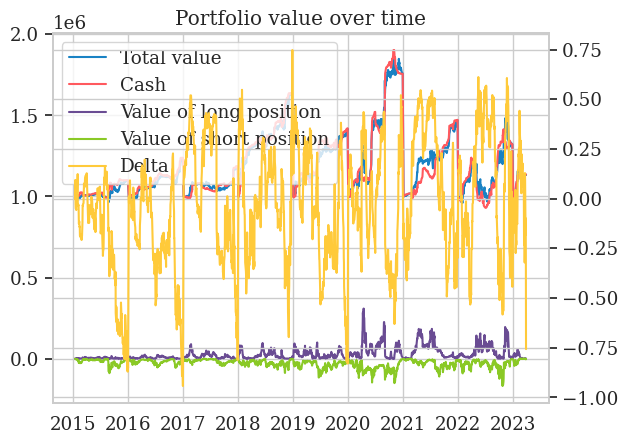

In [ ]:
if run_optimizing == False:
    plot(total_dataframe_for_analysis)

In [ ]:
if google_colab == True:
    if lstm_mlp:
        total_dataframe_for_analysis.to_csv('/content/drive/My Drive/01. Masters Thesis - Shared/07. Trading/Results/LSTM_MLP.csv')
    if bs_rolling:
        total_dataframe_for_analysis.to_csv('/content/drive/My Drive/01. Masters Thesis - Shared/07. Trading/Results/BS_Rolling.csv')
    if bs_garch:
        total_dataframe_for_analysis.to_csv('/content/drive/My Drive/01. Masters Thesis - Shared/07. Trading/Results/BS_GARCH.csv')
    if bs_iv:
        total_dataframe_for_analysis.to_csv('/content/drive/My Drive/01. Masters Thesis - Shared/07. Trading/Results/BS_IV.csv')
    if heston:
        total_dataframe_for_analysis.to_csv('/content/drive/My Drive/01. Masters Thesis - Shared/07. Trading/Results/Heston.csv')

## Threshold search

In [ ]:
if run_optimizing:
    # Initialize wandb
    !pip install wandb
    import wandb
    wandb.login(key="b47bcf387a0571c5520c58a13be35cda8ada0a99")

    # Define the hyperparameters
    sweep_config = {
    'method': 'grid',
    'name': '2015-2018 - v12',
    'metric': {
        'goal': 'maximize', 
        'name': 'alpha'
        },
    'parameters': {
        'buy_threshold': {
            'values': [0.06, 0.1, 0.12]},
        'sell_threshold': {
            'values': [0.06, 0.1, 0.12]},
        'price_cap_lower': {
            'values': [1, 2]},
        'investment_ratio': {
            'values': [5e-4, 5e-5, 5e-6]},
        'long_short_ratio': {
            'values': [0.05, 0.3]}
        }
    }
    sweep_id = wandb.sweep(sweep=sweep_config, project='options-trading') 


In [ ]:
if run_optimizing:
    def find_best_thresholds(df = df):
        run = wandb.init(project = "options-trading")
        df = df.copy()
        buy_signal, sell_signal = generate_buy_sell_signals(df, run.config.buy_threshold, run.config.sell_threshold)
        df = trader(df, buy_signal, sell_signal, starting_balance=100000, price_cap_lower = run.config.price_cap_lower, investment_ratio = run.config.investment_ratio, long_short_ratio = run.config.long_short_ratio)
        df = calculate_options_value(df)
        run.log({"buy_threshold": run.config.buy_threshold, "sell_threshold": run.config.sell_threshold, "sharpe_ratio": sharpe_ratio_monthly(df), "ending_balance": df['Balance'].iloc[-1], "number_of_trades": df['Signal'].abs().sum(), "alpha": capm_alpha(df), "long_short_ratio": run.config.long_short_ratio, "price_cap_lower": run.config.price_cap_lower, "investment_ratio": run.config.investment_ratio})
        # Wandb callback
        print_results(df, 100000)
        plot(df)
        run.finish()

    wandb.agent(sweep_id=sweep_id, function=find_best_thresholds, project='options-trading', count = 1000)